In [ ]:
# Import libraries

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [101]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Keep only rows that have pcdr_ values (lb, ub]
# Very low cdr values generally indicate that the disc segmentation is not great
# Very high cdr values generally indicate that cup and disc ellipses are very close together
lb = 0.1 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1 --> cup and disc ellipses are the same
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

6437
6361


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

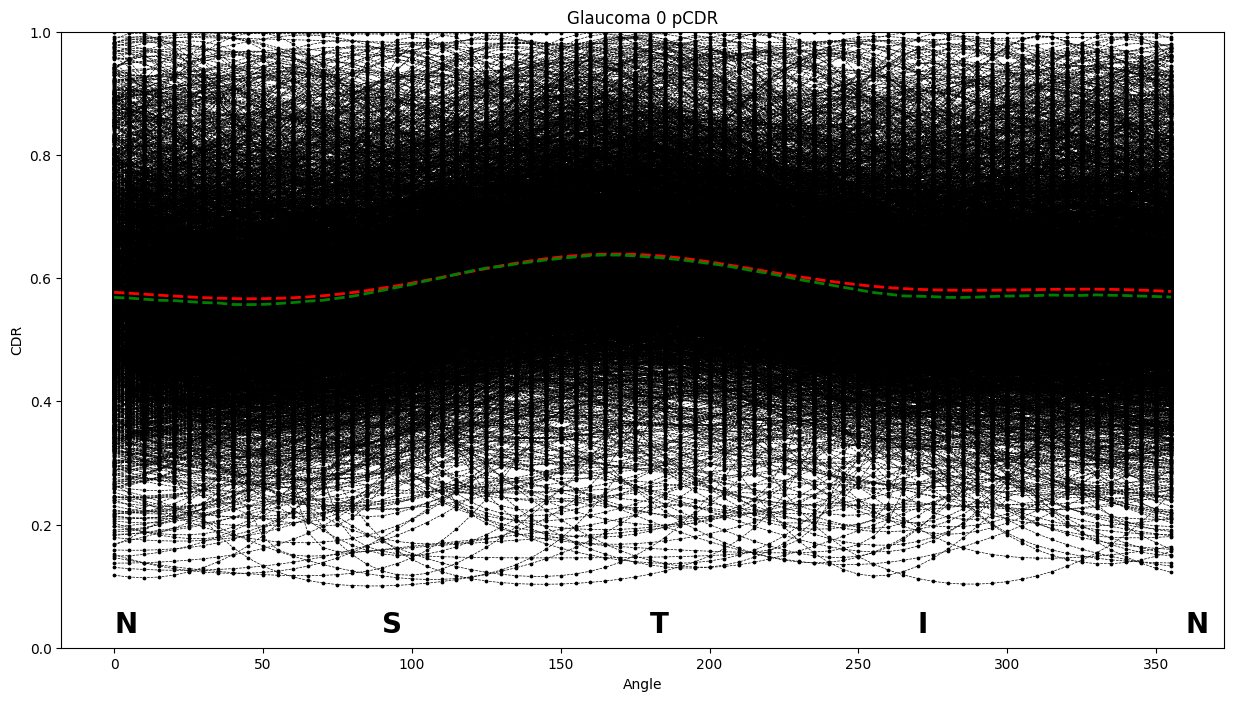

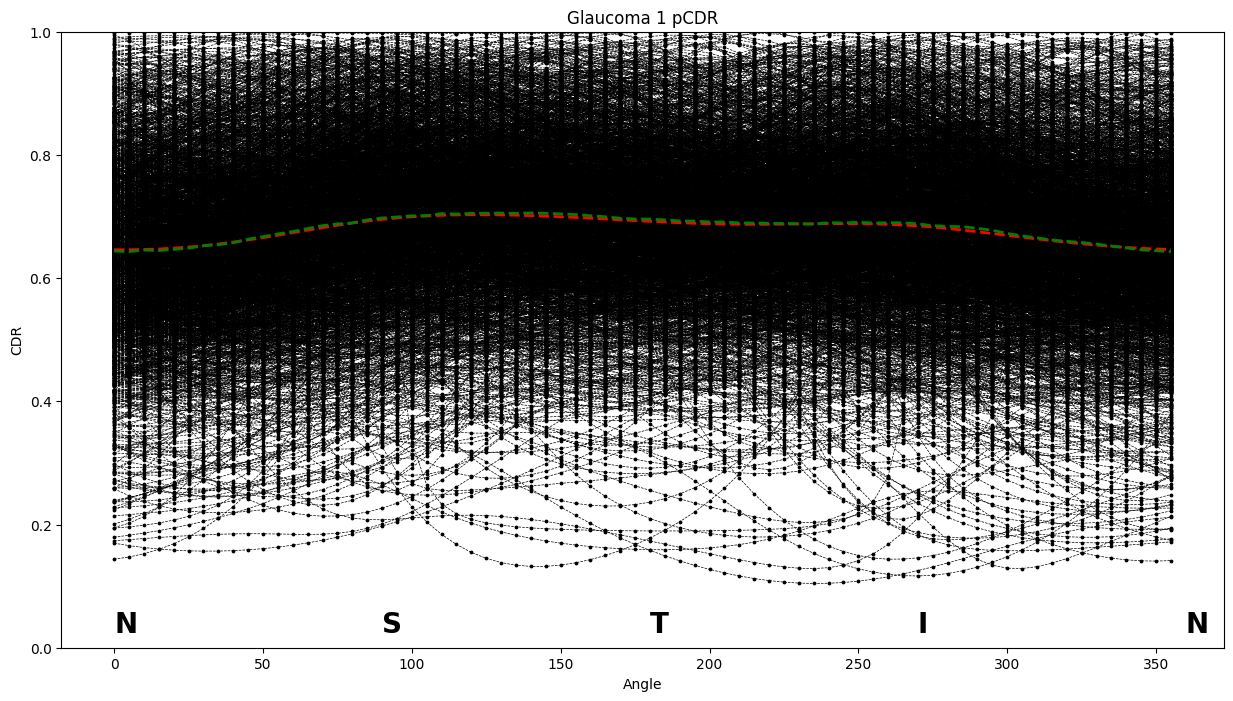

In [102]:
# Group by glaucoma status
df_grouped = df.groupby('glaucoma')

# Plot pcdr values
for name, group in df_grouped:
    plt.figure(figsize=(15, 8))
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    plt.show()